## Example: Spatial Dependence over the same study extent but for different elements

We will compare spatial dependece index of four elements: cadmium, copper, lead, and zinc. We use *meuse* dataset. The dataset comes from:

<br>

> Pebesma, Edzer. (2009). The meuse data set: a tutorial for the gstat R package -> [link to the publication](https://cran.r-project.org/web/packages/gstat/vignettes/gstat.pdf)

In [69]:
import numpy as np
import pandas as pd
import pyinterpolate as ptp

In [70]:
MEUSE_FILE = 'meuse/meuse.csv'

# Variogram parameters
STEP_SIZE = 100
MAX_RANGE = 1600
ALLOWED_MODELS = ['linear', 'spherical']


# Elements
ELEMENTS = ['cadmium', 'copper', 'zinc', 'lead']
COLS = ['x', 'y']
COLS.extend(ELEMENTS)

In [71]:
df = pd.read_csv(MEUSE_FILE, usecols=COLS)
df.head()

,x,y,cadmium,copper,lead,zinc
0,181072,333611,11.7,85,299,1022
1,181025,333558,8.6,81,277,1141
2,181165,333537,6.5,68,199,640
3,181298,333484,2.6,81,116,257
4,181307,333330,2.8,48,117,269


cadmium
Optimal model for element cadmium has 28.40% of nugget to sill ratio. Spatial Dependence is moderate.


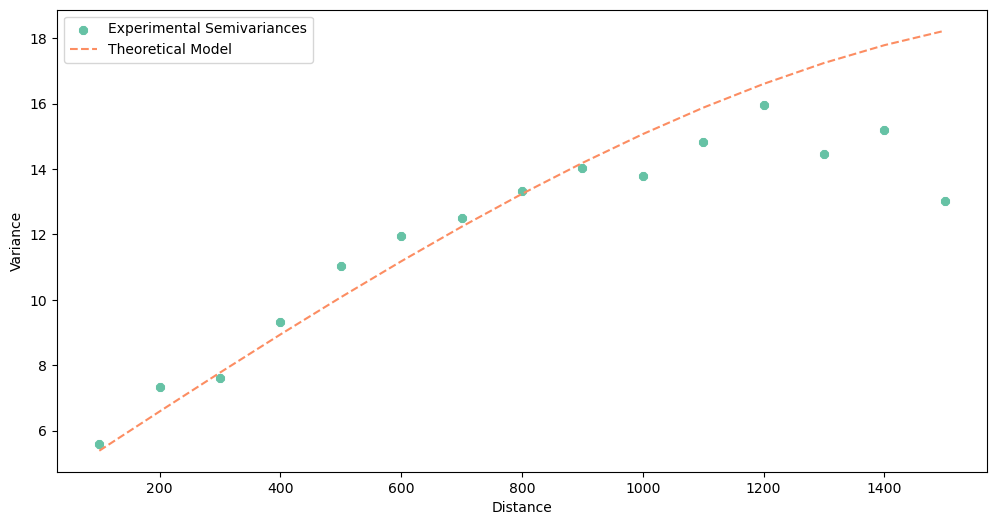


---

copper
Optimal model for element copper has 31.73% of nugget to sill ratio. Spatial Dependence is moderate.


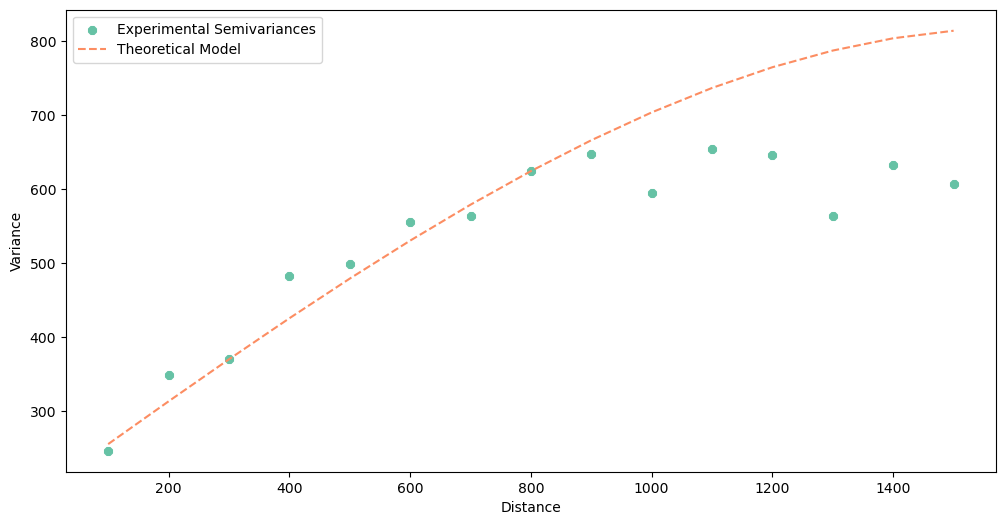


---

zinc
Optimal model for element zinc has 9.56% of nugget to sill ratio. Spatial Dependence is strong.


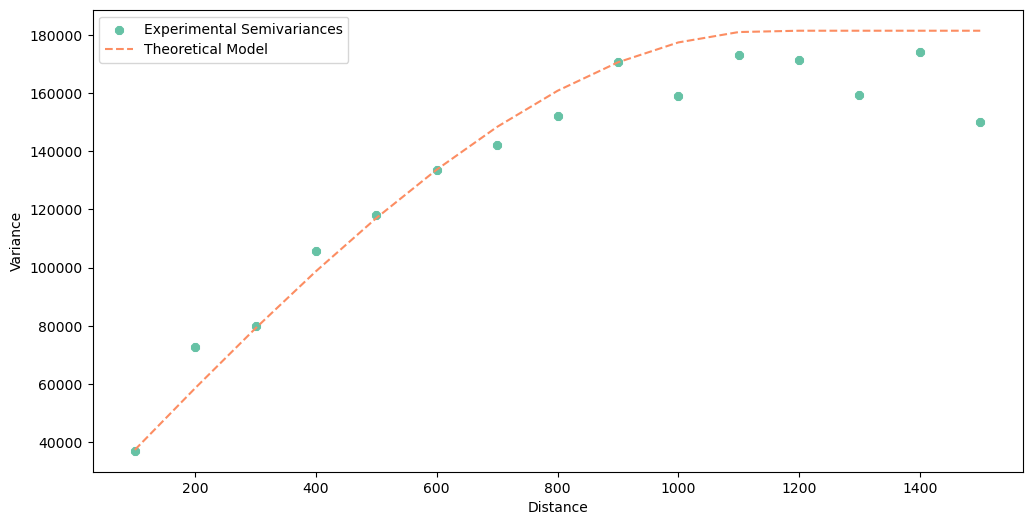


---

lead
Optimal model for element lead has 10.86% of nugget to sill ratio. Spatial Dependence is strong.


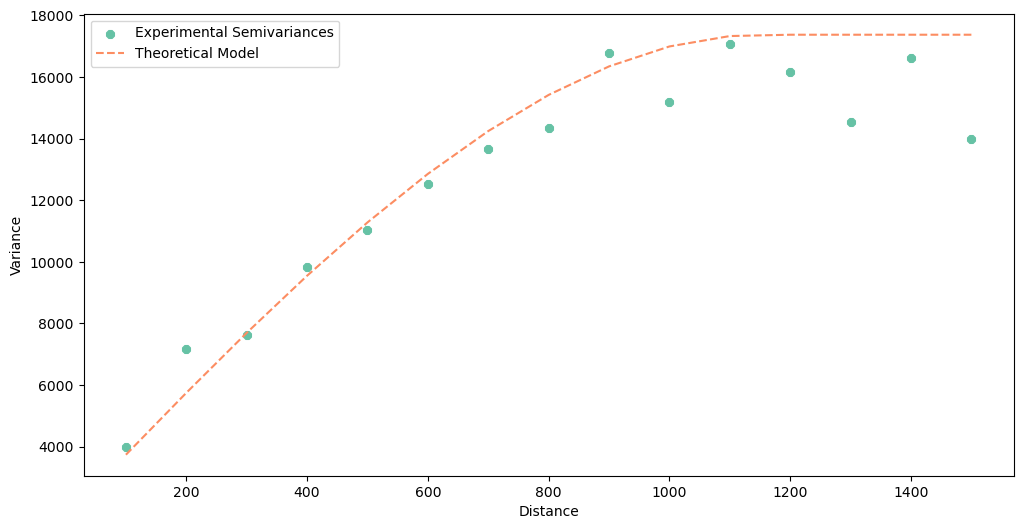


---



In [92]:
opt_models = {}

for element in ELEMENTS:
    print(element)
    # Prepare data
    ds = df[['x', 'y', element]].copy()
    ds[element] = ds[element]
    arr = ds.values
    
    # Get experimental variogram
    exp_var = ptp.build_experimental_variogram(arr, step_size=STEP_SIZE, max_range=MAX_RANGE)
    
    # Find optimal theoretical model
    _sill = np.mean(exp_var.experimental_semivariances[-5:])
    optimal_model = ptp.TheoreticalVariogram()
    optimal_model.autofit(experimental_variogram=exp_var,
                          model_types=ALLOWED_MODELS,
                          max_nugget=0.8,
                          max_range=0.8,
                          deviation_weighting='closest',
                          sill=_sill
                         )
    print('Optimal model for element {} has {:.2f}% of nugget to sill ratio. Spatial Dependence is {}.'.format(
        element, optimal_model.spatial_dependency_ratio, optimal_model.spatial_dependency_strength
    ))
    optimal_model.plot()
    
    opt_models[element] = optimal_model
    
    print('\n---\n')
    

In [93]:
import matplotlib.pyplot as plt
import geopandas as gpd

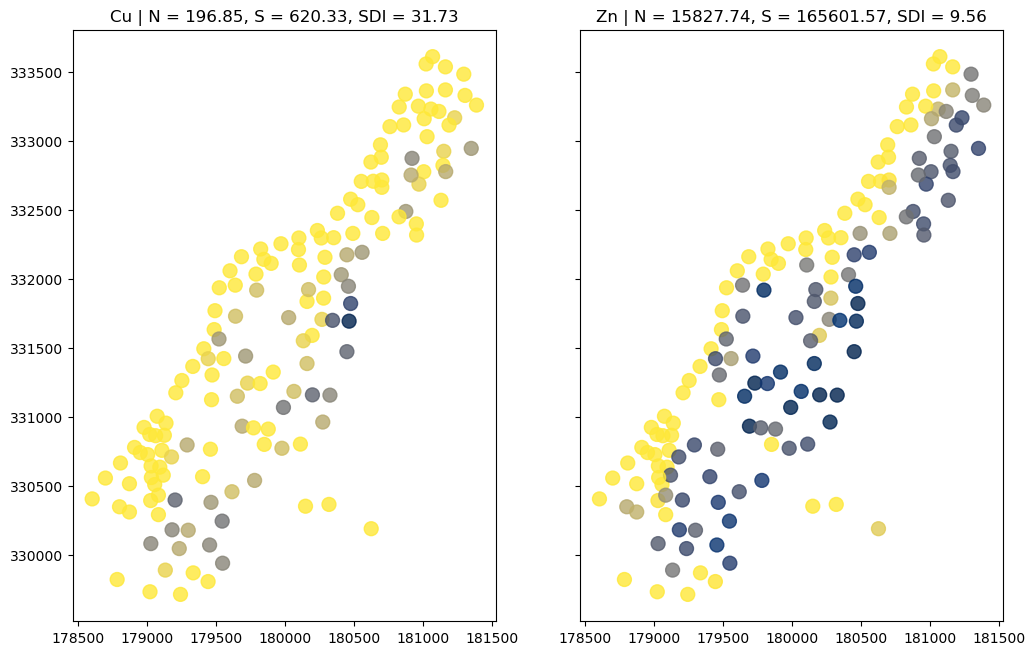

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 18))

gdf = gpd.GeoDataFrame(df[['x', 'y', 'copper', 'zinc']].copy())
gdf.geometry = gpd.points_from_xy(gdf['x'], gdf['y'])
    
c_mean = gdf['copper'].mean()
cnugget = np.sqrt(opt_models['copper'].nugget)
csill = np.sqrt(opt_models['copper'].sill)
    
z_mean = gdf['zinc'].mean()
znugget = np.sqrt(opt_models['zinc'].nugget)
zsill = np.sqrt(opt_models['zinc'].sill)
    
gdf.plot(
    ax=axes[0],
    column='copper',
    cmap='cividis',
    markersize=100,
    alpha=0.8,
    vmin=cnugget,
    vmax=csill
)

gdf.plot(
    ax=axes[1],
    column='zinc',
    cmap='cividis',
    markersize=100,
    alpha=0.8,
    vmin=znugget,
    vmax=zsill
)

cu_desc = 'Cu | N = {:.2f}, S = {:.2f}, SDI = {:.2f}'.format(
    opt_models['copper'].nugget, opt_models['copper'].sill, opt_models['copper'].spatial_dependency_ratio
)

zn_desc = 'Zn | N = {:.2f}, S = {:.2f}, SDI = {:.2f}'.format(
    opt_models['zinc'].nugget, opt_models['zinc'].sill, opt_models['zinc'].spatial_dependency_ratio
)


axes[0].set_title(cu_desc)
axes[1].set_title(zn_desc)

plt.show()

---